In [1]:
import sklearn.kernel_ridge
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from tqdm import tqdm

In [2]:
# Adjust the paths to the validation set and the results derived with the --val flag
val_dataset = h5py.File("/extravolume/data/icemapper/val.hdf5", "r")
results = h5py.File("outputs/20241009_ICEmapper_v2_grdinsar/probs_val.hdf5", "r")

In [3]:
tiles_to_visualise = np.random.choice(list(results.keys()), 5)
tiles_to_visualise

array(['SVAL-10-38_2020_ro14', 'SVAL-35-41_2016_ro174',
       'SVAL-32-49_2016_ro174', 'SVAL-23-43_2020_ro174',
       'SVAL-19-22_2017_ro14'], dtype='<U21')

In [4]:
def shannon_entropy(x, eps=1e-6, C=2):
    x = np.clip(x, eps, 1 - eps)
    return -np.sum(x * np.log(x) / np.log(C), axis=-1)


def shannon_confidence(x):
    return 1 - shannon_entropy(x)

In [5]:
import joblib


def predict_batch(model, batch):
    return model.predict(batch)


def calibrate_confidence(conf, calibration_model, n_jobs=-1, batch_size=2024):
    height, width = conf.shape
    _conf = np.reshape(conf, (height * width, 1))
    batched = [_conf[i: i+batch_size] for i in range(0, len(_conf), batch_size)]
    # conf = calibration_model.predict(conf)
    calibrated_conf = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(predict_batch)(calibration_model, batch) for batch in batched
    )
    calibrated_conf = np.concatenate(calibrated_conf)
    calibrated_conf[calibrated_conf < 0] = 0
    calibrated_conf[calibrated_conf > 1] = 1
    calibrated_conf = np.reshape(calibrated_conf, (height, width))
    return calibrated_conf

In [6]:
def visualise_val_tiles(conf_estimator=shannon_confidence, calibration_model=None, suffix=""):
    nrows, ncols = 4, len(tiles_to_visualise)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3.5*ncols, 3.6*nrows))

    for col, tile in enumerate(tiles_to_visualise):
        pad_height, pad_width = val_dataset[tile].attrs["pad_height"], val_dataset[tile].attrs["pad_width"]
        orig_height, orig_width = val_dataset[tile].attrs["orig_height"], val_dataset[tile].attrs["orig_width"]
        y_slice, x_slice = slice(pad_height, pad_height + orig_height), slice(pad_width, pad_width + orig_width)
        
        thumbnail = np.array(val_dataset[tile]["grd"])[8, :, :, 0]
        thumbnail = thumbnail[y_slice, x_slice]
        
        axes[0][col].set_title(tile)
        axes[0][col].imshow(thumbnail, aspect="auto")
        
        groundtruth = np.array(val_dataset[tile]["outlines"])[:, :, -1]
        groundtruth = groundtruth[y_slice, x_slice]
        axes[1][col].imshow(groundtruth, cmap="gray", interpolation="none", aspect="auto")
        
        output_colors = ["black", "white", "red", "green"]
        output_cmap = mpl.colors.ListedColormap(output_colors, 4)
        
        probs = np.array(results[tile]["probs"])
        predicted = (probs[..., -1] > 0.5)
        output = np.zeros(predicted.shape)
        output[(predicted == 1) & (groundtruth == 1)] = 1
        output[(predicted == 0) & (groundtruth == 1)] = 2
        output[(predicted == 1) & (groundtruth == 0)] = 3
        axes[2][col].imshow(output / 3, cmap=output_cmap, interpolation="none", aspect="auto", vmin=0, vmax=1)
        
        conf = conf_estimator(probs)
        if calibration_model:
            conf = calibrate_confidence(conf, calibration_model)
        neg = axes[3][col].imshow(conf, aspect="auto", vmin=0, vmax=1)
        
        conf_band = np.zeros((*conf.shape, 4))
        conf_band[:, :, 0] = 1
        conf_band[:, :, 3] = (conf < 0.95) * 0.5
        axes[3][col].imshow(conf_band, aspect="auto", vmin=0.95, vmax=1)

    for row in range(nrows):
        for col in range(ncols):
            axes[row][col].axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join("figures", f"tiles_val_uncertainty{suffix}.pdf"))
    plt.show()
    plt.close()

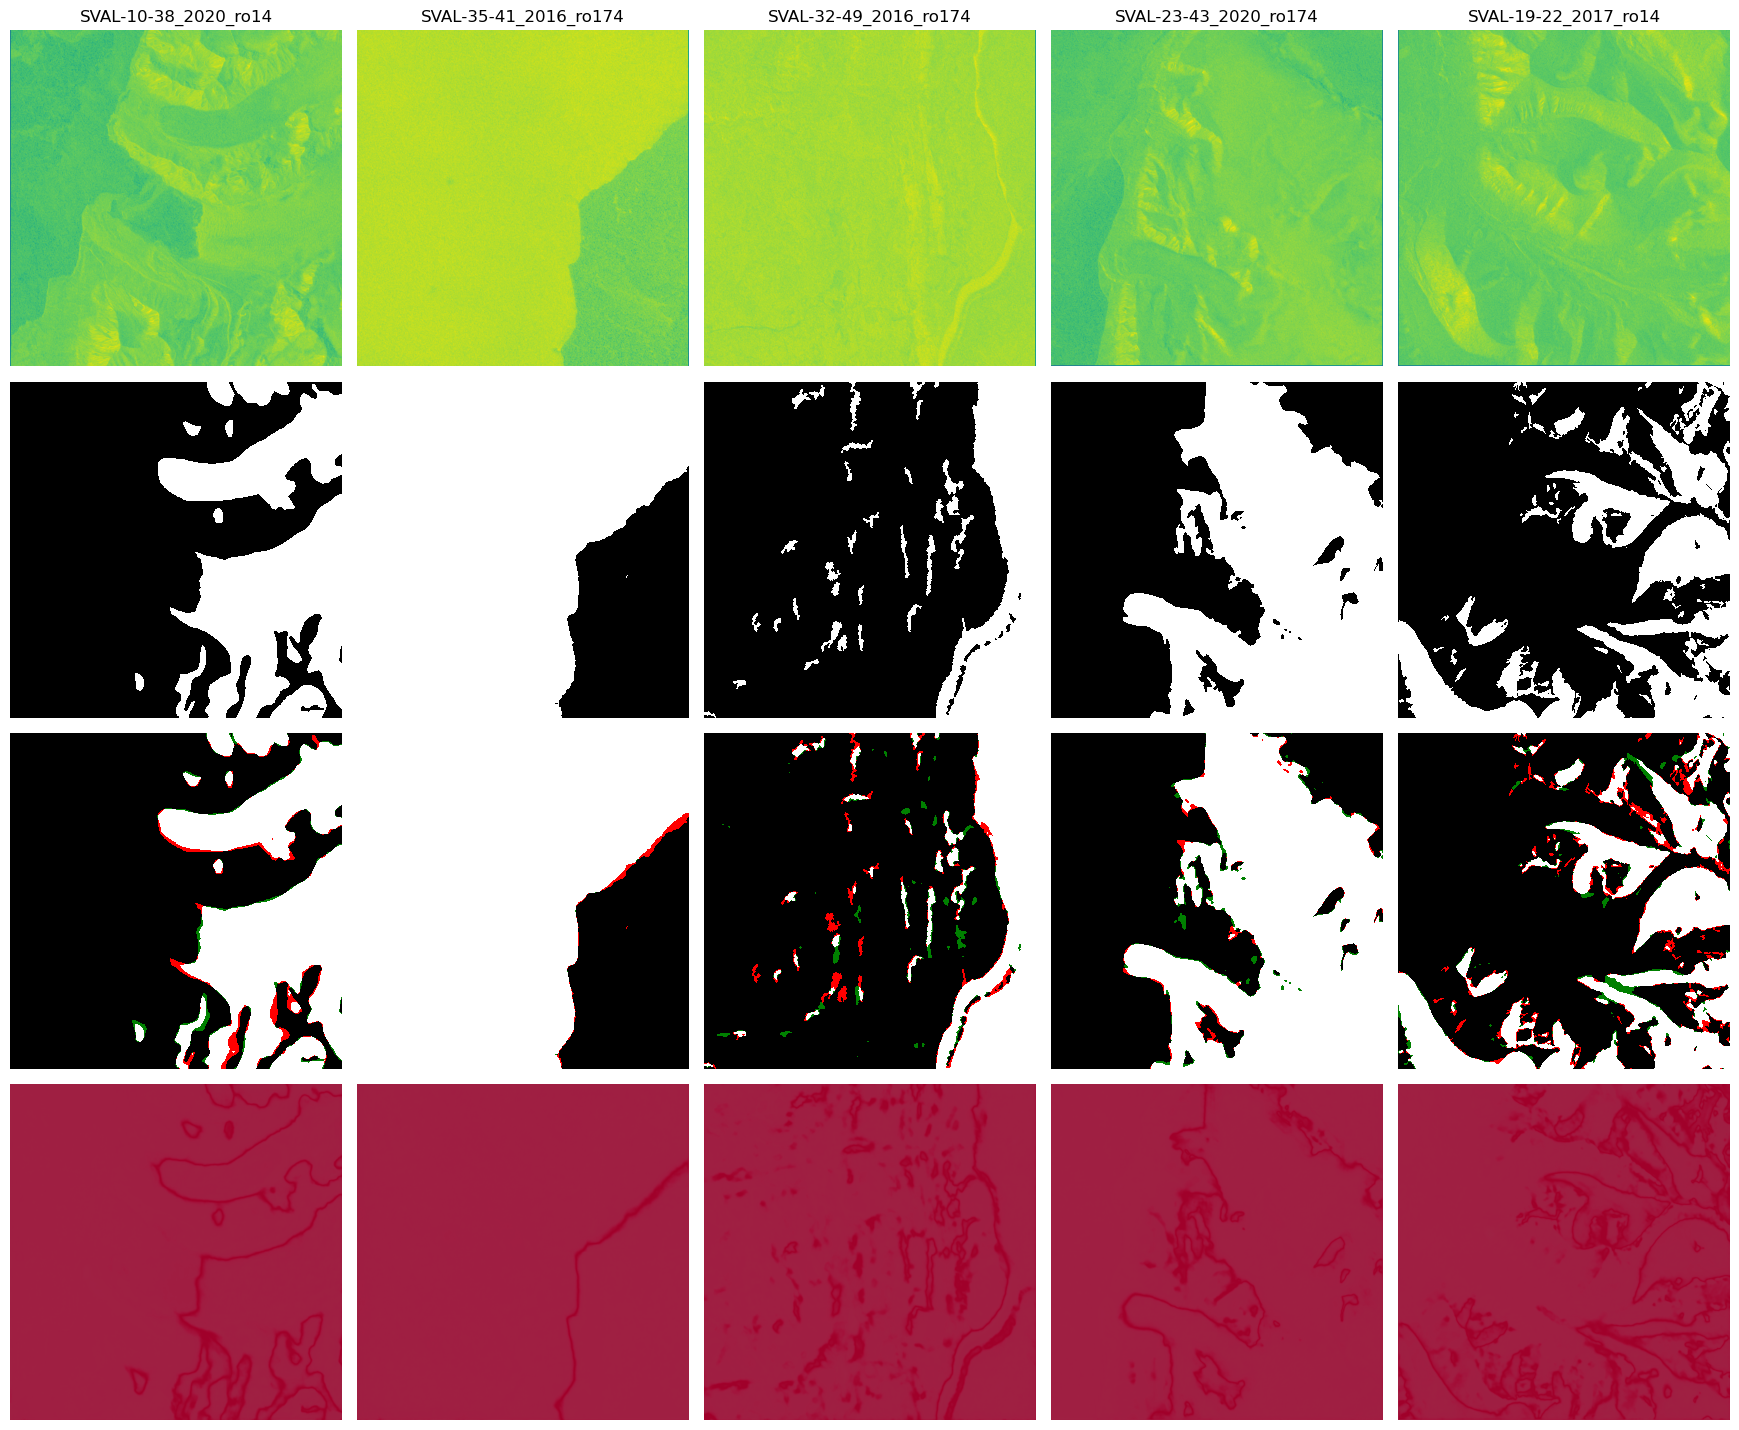

In [7]:
# Adjust the suffix as needed to save the figure
visualise_val_tiles(suffix="_uncalibrated")

In [10]:
def get_reliability_stats(n_bins=10, conf_estimator=shannon_confidence, calibration_model=None):
    bins = [(i * 1 / n_bins, (i + 1) * 1 / n_bins) for i in range(n_bins)]
    accuracies = [0 for _ in bins]
    confs = [0 for _ in bins]
    counts = [0 for _ in bins]
    
    for group in tqdm(results.keys()):
        pad_height, pad_width = val_dataset[group].attrs["pad_height"], val_dataset[group].attrs["pad_width"]
        orig_height, orig_width = val_dataset[group].attrs["orig_height"], val_dataset[group].attrs["orig_width"]
        y_slice, x_slice = slice(pad_height, pad_height + orig_height), slice(pad_width, pad_width + orig_width)
        
        groundtruth = val_dataset[group]["outlines"][:, :, -1]
        groundtruth = groundtruth[y_slice, x_slice]
        
        probs = np.array(results[group]["probs"]).astype(np.double)
        prediction = (probs[..., -1] > 0.5)

        tp = (prediction == 1) & (groundtruth == 1)
        tn = (prediction == 0) & (groundtruth == 0)

        conf = conf_estimator(probs)
        if calibration_model:
            conf = calibrate_confidence(conf, calibration_model)

        for bin_idx, (l, r) in enumerate(bins):
            mask = (conf >= l) & (conf < r)
            counts[bin_idx] += np.sum(mask)
            confs[bin_idx] += np.sum(conf[mask])
            accuracies[bin_idx] += (np.sum(tp[mask]) + np.sum(tn[mask]))
            
    confs = [conf / count for conf, count in zip(confs, counts)]
    accuracies = [acc / count for acc, count in zip(accuracies, counts)]
    
    ece = [count * np.abs(conf - acc) for count, conf, acc in zip(counts, confs, accuracies)]
    ece = np.nansum(ece) / np.nansum(counts)
    
    return bins, confs, accuracies, counts, ece

In [11]:
pre_calib_n10_results = get_reliability_stats(10)
pre_calib_n100_results = get_reliability_stats(100)

100%|████████████████████████████████████████████████████████████████████████████████████| 338/338 [00:21<00:00, 15.47it/s]
/tmp/ipykernel_1553158/43558186.py:31: RuntimeWarning: invalid value encountered in scalar divide
  confs = [conf / count for conf, count in zip(confs, counts)]
/tmp/ipykernel_1553158/43558186.py:32: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = [acc / count for acc, count in zip(accuracies, counts)]
100%|████████████████████████████████████████████████████████████████████████████████████| 338/338 [00:54<00:00,  6.15it/s]


In [14]:
with open("source_data/pre_calib_n10_results.pickle", "wb") as dst:
    pickle.dump(pre_calib_n10_results, dst)
with open("source_data/pre_calib_n100_results.pickle", "wb") as dst:
    pickle.dump(pre_calib_n100_results, dst)

In [15]:
with open("confidence_calibration_models/confidence_calibration_model_ICEmapper_v2_grdinsar.pickle", "rb") as src:
    calib_model = pickle.load(src)

In [16]:
calib_model

KernelRidge(alpha=array([0.        , 0.00325696, 0.00381337, 0.00395205, 0.00402374,
       0.00406362, 0.00408146, 0.00408847, 0.00408211, 0.00406639,
       0.00404142, 0.00400702, 0.00396034, 0.00390088, 0.00381044,
       0.00364085, 0.00345352, 0.00313871, 0.00231086, 0.        ,
       0.00251394, 0.00452782, 0.00475953, 0.00502358, 0.00541537,
       0.00559831, 0.00572262, 0.0058381 , 0.0059395 , 0.00602521,
       0.00609582, 0.00616372, 0.00623922, 0.00630453, 0.00638095,
       0.00644069, 0.00650611, 0.00658154, 0.00672381, 0.00684534,
       0.00698164, 0.00708493, 0.00715283, 0.00727781, 0.00740511,
       0.00763592, 0.00780528, 0.00794051, 0.00795225, 0.00793486,
       0.00798457, 0.00805808, 0.00812612, 0.00825161, 0.        ]),
            kernel='laplacian')

In [17]:
post_calib_n10_results = get_reliability_stats(10, calibration_model=calib_model)
post_calib_n100_results = get_reliability_stats(100, calibration_model=calib_model)

100%|████████████████████████████████████████████████████████████████████████████████████| 338/338 [02:50<00:00,  1.98it/s]


In [18]:
with open("source_data/post_calib_n10_results.pickle", "wb") as dst:
    pickle.dump(post_calib_n10_results, dst)
with open("source_data/post_calib_n100_results.pickle", "wb") as dst:
    pickle.dump(post_calib_n100_results, dst)

In [83]:
def plot_reliability_stats(reliability_stats, ece=None, n_ece_bins=None, markerscale=None, path=None):
    bins, confs, accuracies, counts, _ = reliability_stats
    n_bins = len(bins)
    
    ms = None
    if markerscale is not None:
        (vmin, vmax), (smin, smax) = markerscale
        ms = ((np.array(counts) - vmin) / (vmax - vmin))**0.2 * smax + smin 
    
    if ece is None:
        ece = reliability_stats[-1]
        n_ece_bins = n_bins
        
    _, ax = plt.subplots(figsize=(3, 3))
    bins_ = [_[0] for _ in bins] + [1]
    ax.hist(bins_[:-1], bins_, weights=accuracies, color=[0, 0, 0, 0.07], edgecolor="white", linewidth=1, zorder=-2)
    ax.plot([0, 1], [0, 1], linestyle="dashed", color="lightgreen", alpha=0.95, zorder=-1)
    ax.plot(confs, accuracies, color="orange", clip_on=False)
    ax.scatter(confs, accuracies, marker=".", color="orange", s=ms, clip_on=False)
    ax.text(1.0, 0.015, f"ECE$_{{{n_ece_bins}}}$ = {ece:.5f}", ha="right", va="bottom", fontsize=12, backgroundcolor="white")
    ax.set_xlabel("Confidence", fontsize=12)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([1 / n_bins * _ for _ in range(n_bins + 1)])
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_yticks([1 / n_bins * _ for _ in range(n_bins + 1)])
    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.tick_params(axis="x", rotation=90)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 4))
    ax.spines["bottom"].set_position(("outward", 4))
    # plt.grid()
    plt.tight_layout()
    if path is not None:
        plt.savefig(path)
    plt.show()
    plt.close()

/tmp/ipykernel_1553158/1050358890.py:8: RuntimeWarning: invalid value encountered in power
  ms = ((np.array(counts) - vmin) / (vmax - vmin))**0.2 * smax + smin


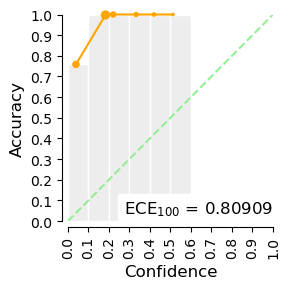

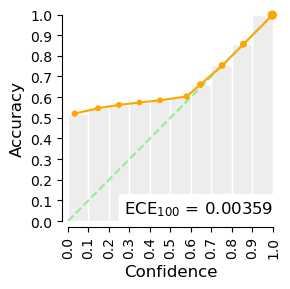

In [84]:
vmin = np.min([np.min([_ for _ in pre_calib_n10_results[-2] if _ != 0]), np.min([_ for _ in post_calib_n10_results[-2] if _ != 0])])
vmax = np.max([pre_calib_n10_results[-2], post_calib_n10_results[-2]])
markerscale = ((vmin, vmax), (10, 120))
plot_reliability_stats(pre_calib_n10_results, ece=pre_calib_n10_results[-1], markerscale=markerscale, n_ece_bins=100, path="figures/pre_calib_reliability.pdf")
plot_reliability_stats(post_calib_n10_results, ece=post_calib_n10_results[-1], markerscale=markerscale, n_ece_bins=100, path="figures/post_calib_reliability.pdf")

In [53]:
vmin, vmax

(41, 319818377)

In [25]:
def get_reliability_diagram(n_bins=10, conf_estimator=shannon_confidence, 
                            calibration_model=None, n_ece_bins=None, suffix=""):
    if n_ece_bins is None:
        n_ece_bins = n_bins
    bins = [(i * 1 / n_bins, (i + 1) * 1 / n_bins) for i in range(n_bins)]
    ece_bins = [(i * 1 / n_ece_bins, (i + 1) * 1 / n_ece_bins) for i in range(n_ece_bins)]
    accuracies = [0 for _ in bins]
    ece_accuracies = [0 for _ in ece_bins]
    confs = [0 for _ in bins]
    ece_confs = [0 for _ in ece_bins]
    counts = [0 for _ in bins]
    ece_counts = [0 for _ in ece_bins]
    
    for group in tqdm(results.keys()):
        pad_height, pad_width = val_dataset[group].attrs["pad_height"], val_dataset[group].attrs["pad_width"]
        orig_height, orig_width = val_dataset[group].attrs["orig_height"], val_dataset[group].attrs["orig_width"]
        y_slice, x_slice = slice(pad_height, pad_height + orig_height), slice(pad_width, pad_width + orig_width)
        
        groundtruth = val_dataset[group]["outlines"][:, :, -1]
        groundtruth = groundtruth[y_slice, x_slice]
        
        probs = np.array(results[group]["probs"]).astype(np.double)
        prediction = (probs[..., -1] > 0.5)

        tp = (prediction == 1) & (groundtruth == 1)
        tn = (prediction == 0) & (groundtruth == 0)

        conf = conf_estimator(probs)
        if calibration_model:
            conf = calibrate_confidence(conf, calibration_model)

        for bin_idx, (l, r) in enumerate(bins):
            mask = (conf >= l) & (conf < r)
            counts[bin_idx] += np.sum(mask)
            confs[bin_idx] += np.sum(conf[mask])
            accuracies[bin_idx] += (np.sum(tp[mask]) + np.sum(tn[mask]))
        
        for bin_idx, (l, r) in enumerate(ece_bins):
            mask = (conf >= l) & (conf < r)
            ece_counts[bin_idx] += np.sum(mask)
            ece_confs[bin_idx] += np.sum(conf[mask])
            ece_accuracies[bin_idx] += (np.sum(tp[mask]) + np.sum(tn[mask]))
            
    confs = [conf / count for conf, count in zip(confs, counts)]
    ece_confs = [conf / count for conf, count in zip(ece_confs, ece_counts)]
    accuracies = [acc / count for acc, count in zip(accuracies, counts)]
    ece_accuracies = [acc / count for acc, count in zip(ece_accuracies, ece_counts)]
    
    ece = [count * np.abs(conf - acc) for count, conf, acc in zip(ece_counts, ece_confs, ece_accuracies)]
    ece = np.nansum(ece) / np.nansum(ece_counts)
    
    bins_ = [_[0] for _ in bins] + [1]
    
    _, ax = plt.subplots(figsize=(5, 5))
    ax.hist(bins_[:-1], bins_, weights=accuracies, color="gray", edgecolor="lightgray")
    ax.plot([0, 1], [0, 1], linestyle="dashed", color="lightgreen", alpha=0.95)
    ax.plot(confs, accuracies, marker="x", color="orange")
    ax.text(1.0, 0.015, f"ECE$_{{{n_ece_bins}}}$ = {ece:.5f}", ha="right", va="bottom", fontsize=16, backgroundcolor="white")
    ax.set_xlabel("Confidence", fontsize=16)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([1 / n_bins * _ for _ in range(n_bins + 1)])
    ax.set_ylabel("Accuracy", fontsize=16)
    ax.set_yticks([1 / n_bins * _ for _ in range(n_bins + 1)])
    ax.tick_params(labelsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(("outward", 4))
    ax.spines['bottom'].set_position(("outward", 4))
    #plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join("figures", f"reliability{suffix}.pdf"))
    plt.show()
    plt.close()
    
    return bins, confs, accuracies, counts, ece

100%|████████████████████████████████████████████████████████████████████████████████████| 338/338 [02:44<00:00,  2.06it/s]
/tmp/ipykernel_2993606/2284942735.py:44: RuntimeWarning: invalid value encountered in scalar divide
  confs = [conf / count for conf, count in zip(confs, counts)]
/tmp/ipykernel_2993606/2284942735.py:45: RuntimeWarning: invalid value encountered in scalar divide
  ece_confs = [conf / count for conf, count in zip(ece_confs, ece_counts)]
/tmp/ipykernel_2993606/2284942735.py:46: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = [acc / count for acc, count in zip(accuracies, counts)]
/tmp/ipykernel_2993606/2284942735.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ece_accuracies = [acc / count for acc, count in zip(ece_accuracies, ece_counts)]


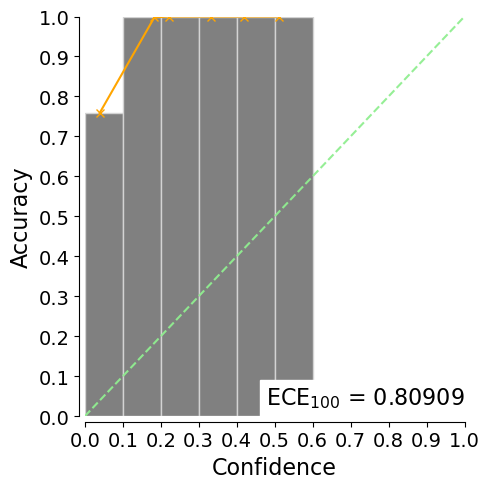

In [26]:
# Adjust the suffix as needed to save the figure
_ = get_reliability_diagram(n_bins=10, n_ece_bins=100, suffix="_uncalibrated")

100%|████████████████████████████████████████████████████████████████████████████████████| 338/338 [01:27<00:00,  3.85it/s]
/tmp/ipykernel_2993606/2284942735.py:44: RuntimeWarning: invalid value encountered in scalar divide
  confs = [conf / count for conf, count in zip(confs, counts)]
/tmp/ipykernel_2993606/2284942735.py:45: RuntimeWarning: invalid value encountered in scalar divide
  ece_confs = [conf / count for conf, count in zip(ece_confs, ece_counts)]
/tmp/ipykernel_2993606/2284942735.py:46: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = [acc / count for acc, count in zip(accuracies, counts)]
/tmp/ipykernel_2993606/2284942735.py:47: RuntimeWarning: invalid value encountered in scalar divide
  ece_accuracies = [acc / count for acc, count in zip(ece_accuracies, ece_counts)]


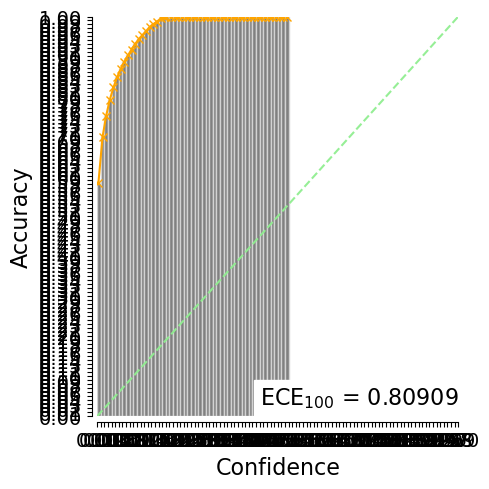

In [27]:
bins, confs, accuracies, counts, _ = get_reliability_diagram(n_bins=100, suffix="tmp")

In [28]:
# in case of a very underconfident model there will be nan values,
# so we filter them out
nan_mask = (np.isnan(confs) | np.isnan(accuracies))
_confs = np.array(confs)[~nan_mask]
_accuracies = np.array(accuracies)[~nan_mask]
_counts = np.array(counts)[~nan_mask]

xs = np.array(_confs)
ys = np.array(_accuracies)

In [29]:
weight_param = 0.1
weights_scale = 1e-2
weights = (_counts / np.max(_counts)) ** weight_param
kernel = "laplacian"

total_xs = np.array([0, *xs, 1])[:, np.newaxis]
total_ys = np.array([0, *ys, 1])
total_weights = np.array([1, *weights, 1])
    
calibration_model = sklearn.kernel_ridge.KernelRidge(alpha=(1 - total_weights) * weights_scale, kernel=kernel)
calibration_model.fit(total_xs, total_ys)

KernelRidge(alpha=array([0.        , 0.00325696, 0.00381337, 0.00395205, 0.00402374,
       0.00406362, 0.00408146, 0.00408847, 0.00408211, 0.00406639,
       0.00404142, 0.00400702, 0.00396034, 0.00390088, 0.00381044,
       0.00364085, 0.00345352, 0.00313871, 0.00231086, 0.        ,
       0.00251394, 0.00452782, 0.00475953, 0.00502358, 0.00541537,
       0.00559831, 0.00572262, 0.0058381 , 0.0059395 , 0.00602521,
       0.00609582, 0.00616372, 0.00623922, 0.00630453, 0.00638095,
       0.00644069, 0.00650611, 0.00658154, 0.00672381, 0.00684534,
       0.00698164, 0.00708493, 0.00715283, 0.00727781, 0.00740511,
       0.00763592, 0.00780528, 0.00794051, 0.00795225, 0.00793486,
       0.00798457, 0.00805808, 0.00812612, 0.00825161, 0.        ]),
            kernel='laplacian')

100%|████████████████████████████████████████████████████████████████████████████████████| 338/338 [04:11<00:00,  1.34it/s]


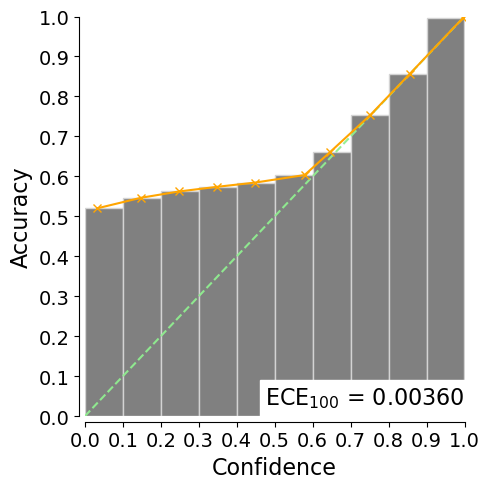

In [36]:
# Adjust the suffix as needed to save the figure
bins, confs, accuracies, counts, _ = get_reliability_diagram(n_bins=10, n_ece_bins=100, calibration_model=calibration_model, suffix="_calibrated")

In [37]:
counts

[1220096,
 502760,
 387897,
 326282,
 287875,
 870442,
 2674411,
 3871805,
 6390506,
 319818397]

100%|████████████████████████████████████████████████████████████████████████████████████| 338/338 [04:41<00:00,  1.20it/s]


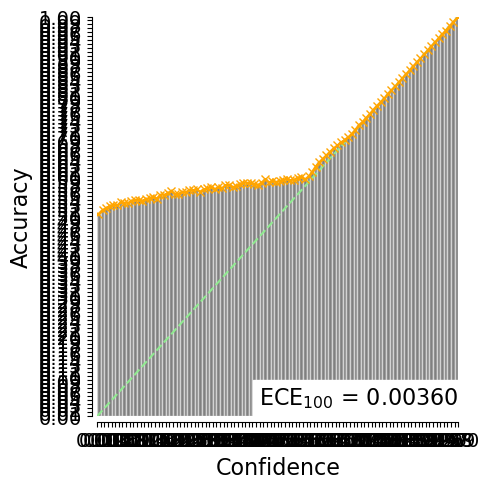

([(0.0, 0.01),
  (0.01, 0.02),
  (0.02, 0.03),
  (0.03, 0.04),
  (0.04, 0.05),
  (0.05, 0.06),
  (0.06, 0.07),
  (0.07, 0.08),
  (0.08, 0.09),
  (0.09, 0.1),
  (0.1, 0.11),
  (0.11, 0.12),
  (0.12, 0.13),
  (0.13, 0.14),
  (0.14, 0.15),
  (0.15, 0.16),
  (0.16, 0.17),
  (0.17, 0.18),
  (0.18, 0.19),
  (0.19, 0.2),
  (0.2, 0.21),
  (0.21, 0.22),
  (0.22, 0.23),
  (0.23, 0.24),
  (0.24, 0.25),
  (0.25, 0.26),
  (0.26, 0.27),
  (0.27, 0.28),
  (0.28, 0.29),
  (0.29, 0.3),
  (0.3, 0.31),
  (0.31, 0.32),
  (0.32, 0.33),
  (0.33, 0.34),
  (0.34, 0.35),
  (0.35, 0.36),
  (0.36, 0.37),
  (0.37, 0.38),
  (0.38, 0.39),
  (0.39, 0.4),
  (0.4, 0.41),
  (0.41, 0.42),
  (0.42, 0.43),
  (0.43, 0.44),
  (0.44, 0.45),
  (0.45, 0.46),
  (0.46, 0.47),
  (0.47, 0.48),
  (0.48, 0.49),
  (0.49, 0.5),
  (0.5, 0.51),
  (0.51, 0.52),
  (0.52, 0.53),
  (0.53, 0.54),
  (0.54, 0.55),
  (0.55, 0.56),
  (0.56, 0.57),
  (0.57, 0.58),
  (0.58, 0.59),
  (0.59, 0.6),
  (0.6, 0.61),
  (0.61, 0.62),
  (0.62, 0.63),
  (0.

In [33]:
get_reliability_diagram(n_bins=100, calibration_model=calibration_model, suffix="tmp2")

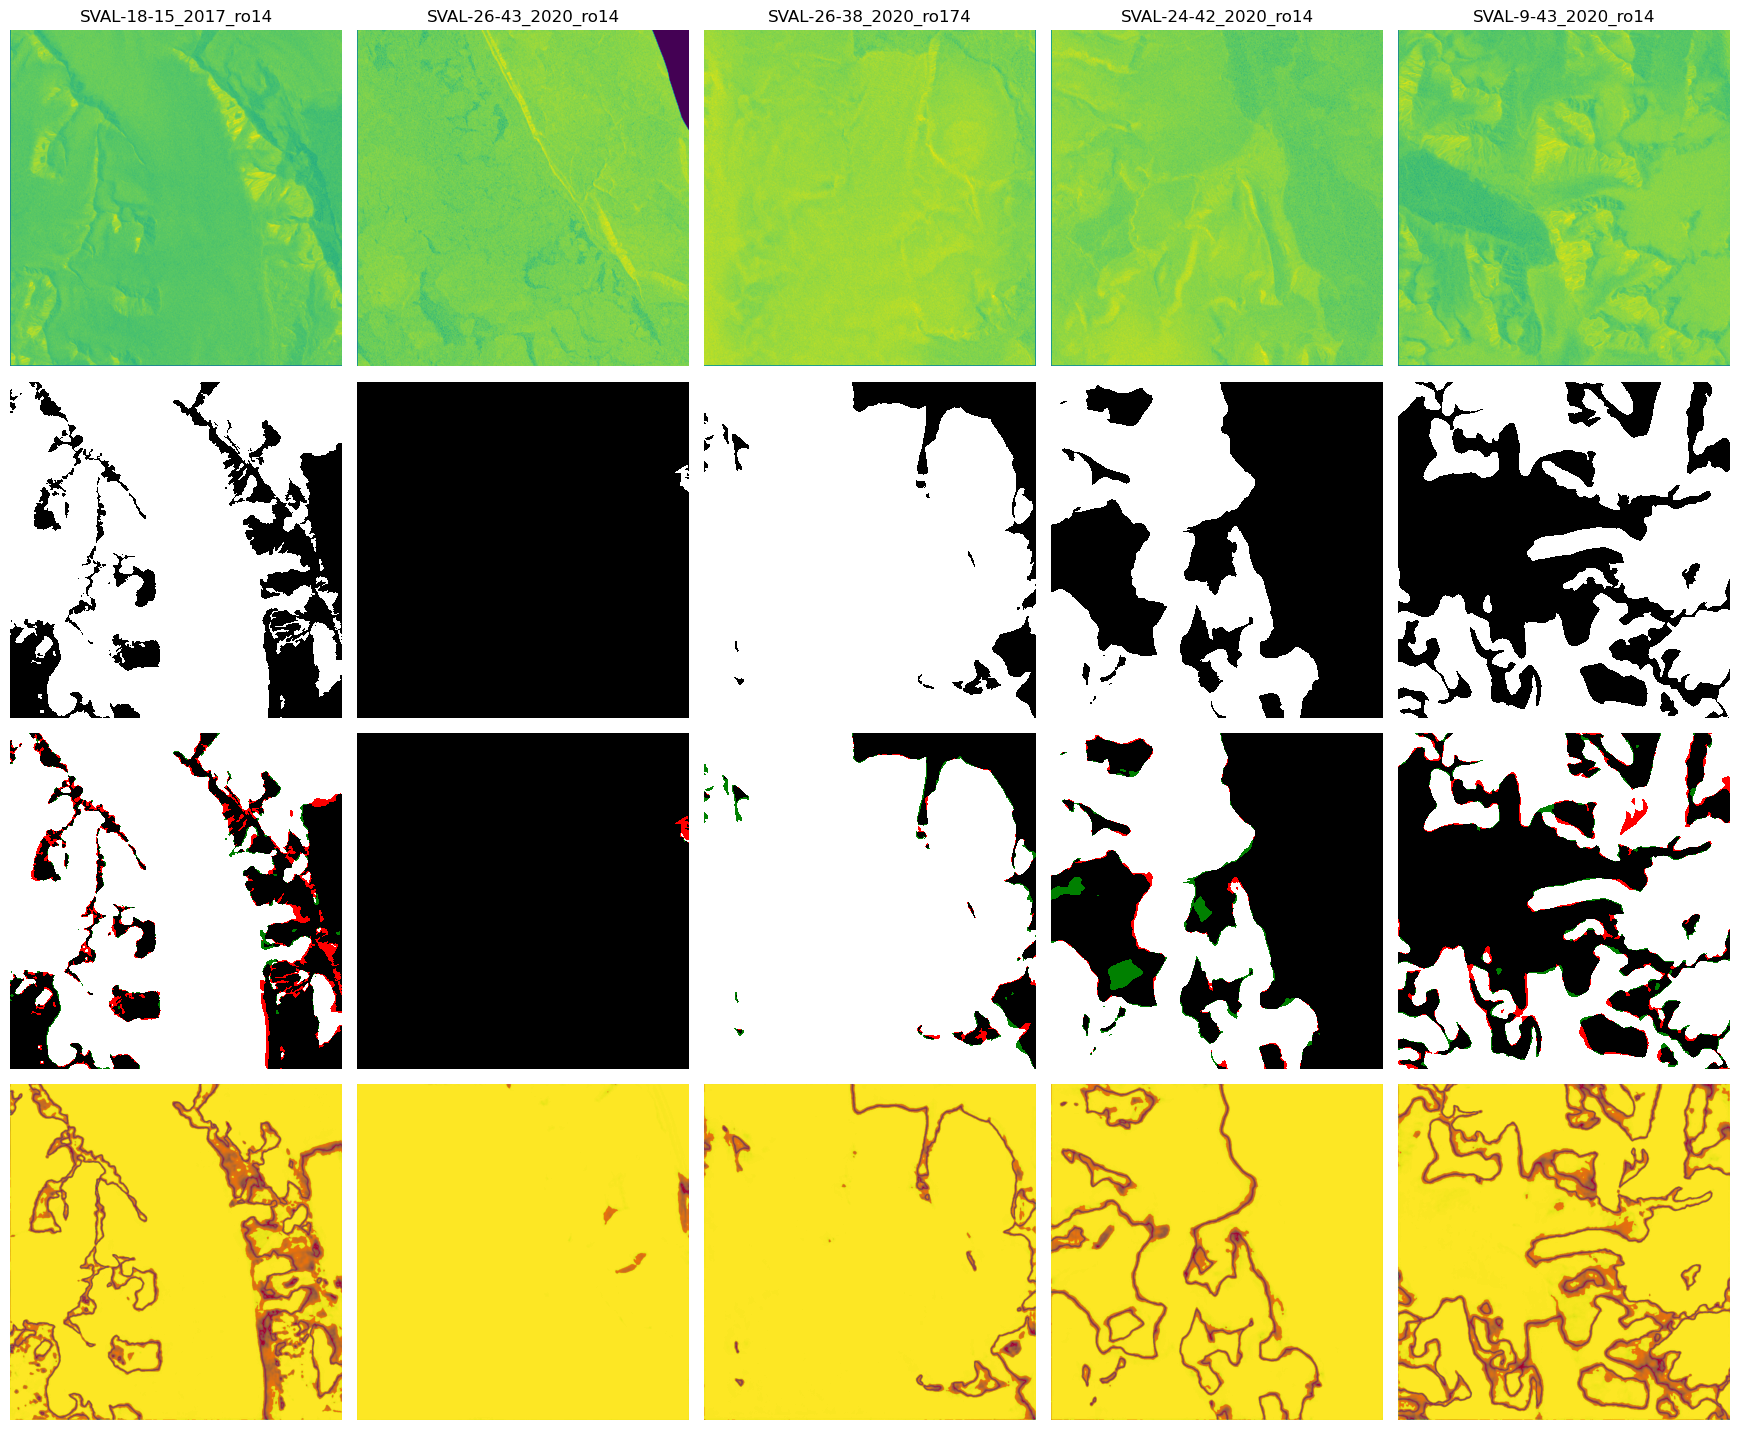

In [35]:
# Adjust the suffix as needed to save the figure
visualise_val_tiles(calibration_model=calibration_model, suffix="_calibrated")

In [32]:
# Adjust the path as needed to save the calibration model
with open(os.path.join("confidence_calibration_models", "confidence_calibration_model_ICEmapper_v2_grdinsar.pickle"), "wb") as file:
    pickle.dump(calibration_model, file)